Supervised Learning - Classification and Regression

# In Depth: Decision Trees and Random Forests

Previously we have looked in depth at a simple generative classifier (naive Bayes) and a powerful discriminative classifier (support vector machines). Here we'll take a look at motivating another poerful algorithm - a non-parametric algorithm calles **random forest**. Random forests are an example of an **ensemble** method, a method that relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater that the parts; that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting! We will see examples of this in the following sections. We begin with the stadard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

Random forests are an example of an **ensemble learner** built on decision trees. For this reason we'll start by dicussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classifiation. For example, if you wanted to build a descision tree to classify an animal you come across while on a hike, you might construct the one shown below:

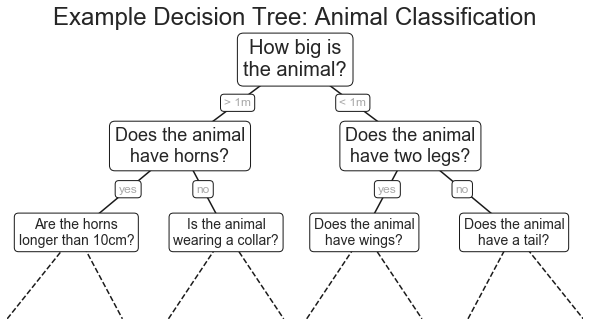

In [2]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

fig.savefig('figures/05.08-decision-tree.png')

The binary splitting makes this extremely efficient: in a well-constructed tree, each question wil cut the number of options by aprroximately half, very quickly narrowing th options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data; that is, each node in the tree spilts the data into two groups using a cutoff value within one of the features. Let's now take a look at an example.

### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

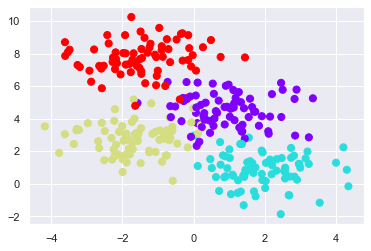

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers =4,
                 random_state=0,cluster_std=1.0)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='rainbow');

A simpe decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. The folloing figure presents a visualization of the first four levels fo a decision tree classifier for this data.

C:\Users\Ulrike Boehm\Documents\repos\PythonDataScience\PythonDataScience\05_MachineLearning\helpers_05_08.py:34: UserWarning: The following kwargs were not used by contour: 'clim'
  zorder=1)
C:\Users\Ulrike Boehm\Documents\repos\PythonDataScience\PythonDataScience\05_MachineLearning\helpers_05_08.py:34: UserWarning: The following kwargs were not used by contour: 'clim'
  zorder=1)
C:\Users\Ulrike Boehm\Documents\repos\PythonDataScience\PythonDataScience\05_MachineLearning\helpers_05_08.py:34: UserWarning: The following kwargs were not used by contour: 'clim'
  zorder=1)
C:\Users\Ulrike Boehm\Documents\repos\PythonDataScience\PythonDataScience\05_MachineLearning\helpers_05_08.py:34: UserWarning: The following kwargs were not used by contour: 'clim'
  zorder=1)


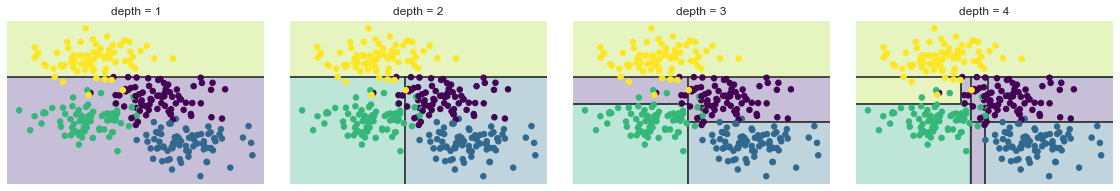

In [4]:
from helpers_05_08 import visualize_tree # helper_05_08 additional Python file in ML folder
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

        
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

fig.savefig('figures/05.08-decision-tree-levels.png')

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. Except for nodes that contain all of one color, at each lebel **every** region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the `DecisionTreeClassifier` estimator:

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X,y)

Let's write a quick utility function to help us visualize the output of the classifier:

In [ ]:
def 

## Ensembles of Estimators: Random Forests

## Random Forest Regression

## Example: Random Forest for Classifying Digits

## Summary of Random Forest

This section contained a brief introduction to the concept of **ensemble estimators**, and in particular the random forest model - an ensemble of randomized decision trees. Random forests are a powerful method with serveral advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the `predict_proba()` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are underfit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable; that is, if you would like to draw conclusions about the **meaning** of the classification model, random forests may not be the best choice.